# Load library

In [1]:
%matplotlib inline
# load library
import numpy as np
import re
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import os,sys

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import svm

from sklearn import metrics

from PIL import Image
from skimage import exposure

# Load functions

In [2]:
###          Functions :  
# ------------------------------------------------------------------------
##     Helper functions
    
# load csv  
def load_train_csv(data_path, sub_sample=False):
    """Loads data and returns HeaderName (Name Column), X (features) and ids (labels)"""
    HeaderName = np.genfromtxt(data_path, delimiter=",", dtype=str, max_rows=1)
    inputData = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    
    ids = inputData[:, :4].astype(np.int)
    X = inputData[:, 4:]
    
    # sub-sample
    if sub_sample:
        X = X[::50]
        ids = ids[::50]

    return HeaderName, ids, X

def load_tree_csv(data_path, sub_sample=False):
    """Loads data and returns HeaderName (Name Column), X (features) and ids (labels)"""
    HeaderName = np.genfromtxt(data_path, delimiter=",", dtype=str, max_rows=1)
    inputData = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    
    ID = inputData[:, 0].astype(np.int)
    CX = inputData[:, 1]
    CY = inputData[:, 2]
    
    return ID, CX, CY

# load image
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w1, w2, h1, h2):
    return im[h1:h2+1, w1: w2+1]

def ismember(A,B, KeepOccur=False):
    '''Return logical index of element position of array A in B'''
    test=np.asarray([a==B for a in A])
    if not KeepOccur:
        return np.sum(test,axis=0)>0
    else:
        return np.sum(test,axis=0)

# ------------------------------------------------------------------------
##     Functions used for extraction of features

# Improve dimensionality of dataset
def Features_Product(a):
    '''Return the product features'''
    # Compute full matrix
    Column_Repet=np.array([np.tile(a[:,c],(a.shape[1],1)) for c in range(a.shape[1])]).reshape(a.shape[1]**2,a.shape[0]).T
    Brut_Product = np.multiply(Column_Repet,np.tile(a, (1,a.shape[1]))).T
    # Filter unique columns
    b = np.ascontiguousarray(Brut_Product).view(np.dtype((np.void, Brut_Product.dtype.itemsize * Brut_Product.shape[1])))
    Unique_Product = np.unique(b).view(Brut_Product.dtype).reshape(-1, Brut_Product.shape[1]).T
    return Unique_Product


# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_segs = quickshift(img,ratio=1, convert2lab='False')
    
    Specific_Seg = []
    for i in np.unique(img_segs):
        Temp = np.array(img)
        Temp[img_segs != i, :] =np.NAN
        Temp = Temp[np.sum(np.isnan(Temp[:,:,0]), axis=1)!=Temp.shape[1],:,:]
        Temp = Temp[:,np.sum(np.isnan(Temp[:,:,0]), axis=0)!=Temp.shape[0],:]
        Specific_Seg.append(Temp)
        del Temp
        
    X = np.asarray([ extract_features(Specific_Seg[i]) for i in range(len(Specific_Seg))])
    return X, img_segs, img

# ------------------------------------------------------------------------
##     Functions used for label assigntion
    
# Assign a groundtruth label for each segment
def value_to_seg(v,Thres):
    df = np.mean(v)
    if df > Thres:
        return 1
    else:
        return 0
    
# ------------------------------------------------------------------------
##     Functions used for model and cross-validation
    
# Split the dataset in testset(X_test,Y_test) and trainset(X,Y)
def my_split_data(x, y, ratio, seed=None):
    """split the dataset based on the split ratio."""
    # set seed
    np.random.seed(seed)
    ind = np.random.permutation(x.shape[0])
    x,y = x[ind], y[ind]
    NumberOfTrained = int(np.floor(ratio * x.shape[0]))
    x_train = x[:NumberOfTrained]
    y_train = y[:NumberOfTrained]
    x_test = x[NumberOfTrained:]
    y_test = y[NumberOfTrained:]
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data based on the given ratio: TODO
    # ***************************************************
    return x_train, y_train, x_test, y_test

def SplitandBalancedata(x, y, ratio, myseed=None):
    """split the dataset based on the split ratio."""
    # set seed
    np.random.seed(myseed)
    # generate random indices
    num_row = len(y)
    indices = np.random.permutation(num_row)
    index_split = int(np.floor(ratio * num_row))
    index_tr = indices[: index_split]
    index_te = indices[index_split:]
    # create split
    x_tr = x[index_tr]
    x_te = x[index_te]
    y_tr = y[index_tr]
    y_te = y[index_te]
    return x_tr, y_tr, x_te, y_tr, y_te

def build_k_StratIndices(y, Balance, seed=None):
    """build k indices for k-fold."""
    # set seed
    np.random.seed(myseed)
    # set parameter
    uid = np.unique(y)
    Cumul = np.asarray([np.int(np.sum(y==uid[i])) for i in range(uid.shape[0])])
    k_fold = np.floor(np.max(Cumul)/Balance)
    Fractions = np.floor(Cumul/k_fold)
    Multiplicateur =  np.max(Fractions) / Fractions
    # initialize
    Y = [ np.asarray([k for k, l in enumerate(y) if l == uid[j] ]) for j in range(uid.shape[0])]
    Y2 = Y[:][:]
    Y2 = [  np.random.permutation(Y2[i]).T for i in range(uid.shape[0]) ]
    k_indices = [ [[] for i in range(uid.shape[0])] for k in range(k_fold) ]
    # loop
    for k in range(k_fold):
        for i in range(uid.shape[0]):
            if len(Y2[i][:]) - 10 < 0:
                Y2[i] = np.append(Y2[i][:], \
                  np.random.permutation(Y[i][~ismember(Y2[i][:],Y[i][:])]))
            
            k_indices[k][i] = Y2[i][:Balance]
            Y2[i]= Y2[i][ ~ismember(k_indices[k][i],Y2[i][:])]
    # formate        
    K_indices = [np.reshape(k_indices[i], (uid.shape[0]*Balance,1)) for i in range(uid.shape[0])]
    return K_indices, Multiplicateur

def CV_F1_TPR(model,X ,Y, k_indices, k):
    # get k'th subgroup in test, others in train
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    y_te = Y[te_indice]
    y_tr = Y[tr_indice]
    x_te = X[te_indice]
    x_tr = X[tr_indice]
    
    # train model
    model.fit(x_tr, y_tr)
    
    # form data with polynomial degree
    # Predict on the training set
    Z_test = model.predict(x_te)
    Z_train = model.predict(x_tr)
    # Get non-zeros in prediction and grountruth arrays
    Z_testn = np.nonzero(Z_test)[0]
    Z_trainn = np.nonzero(Z_train)[0]
    Y_testn = np.nonzero(y_te)[0]
    Y_trainn = np.nonzero(y_tr)[0]
    
    # Compute scores
    TPR_testc = len(list(set(Y_testn) & set(Z_testn))) / float(len(Y_testn))
    score_testc = metrics.f1_score(y_te,Z_test)

    TPR_trainc = len(list(set(Y_trainn) & set(Z_trainn))) / float(len(Y_trainn))
    score_trainc = metrics.f1_score(y_tr,Z_train)
    return score_trainc, score_testc, TPR_trainc, TPR_testc
# ------------------------------------------------------------------------
##     Functions of visualisation
    
# 
def result_vis(C, score_test, score_train, TPR_test, TPR_train, usePca, balance):
    plt.semilogx(C, np.asarray(score_train), marker=".", color='b', label='train Fmeasure')
    plt.semilogx(C, np.asarray(score_test), marker=".", color='r', label='test Fmeasure')
    plt.semilogx(C, np.asarray(TPR_train), marker=".",linestyle="--", color='b', label='train True P.R.')
    plt.semilogx(C, np.asarray(TPR_test), marker=".",linestyle="--", color='r', label='test True P.R.')
    plt.xlabel("Lambda")
    plt.ylabel("Score")
    if usePca and balance:
        plt.title("cross validation: svmRBF, features: reduced, class: balanced")
    elif usePca and balance ==0:
        plt.title("cross validation: LinearSVC, features: reduced")
    elif usePca==0 and balance :
        plt.title("cross validation: svmRBF, class: balanced")
    elif usePca ==0 and balance ==0:
        plt.title("cross validation: LinearSVC")
    plt.legend(loc=0)
    plt.grid(True)
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
# ------------------------------------------------------------------------
##     Functions of converstion to submission

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

def concatenate_images_test(gt_img):
    nChannels = len(gt_img.shape)
    
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    
    if nChannels == 3:
        cimg = gt_img
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        cimg = gt_img_3c
    return cimg

# Display prediction as an image
def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

def label_to_img(img_segments, Zi):
    im = np.array(img_segments)
    for i,j in enumerate(np.unique(img_segments)):
        im[img_segments==j] = Zi[i]
    return im

def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/
    human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]




# Check tree position 

In [3]:
# Script control
# Verify quality labeling of segmentation by ploting segments and segmented groundtruth of image I

from osgeo import gdal
import sys

src_ds = gdal.Open( "HyperSpecFile/M0073_EPFL__140718_a02c_v4_Part_0_refl_Swiss.img" )
if src_ds is None:
    print('Unable to open .img file')
    sys.exit(1)

print("[ RASTER BAND COUNT ]: ", src_ds.RasterCount)
for band in range( src_ds.RasterCount ):
    band += 1
    print("[ GETTING BAND ]: ", band)
    srcband = src_ds.GetRasterBand(band)
    if srcband is None:
        continue

    stats = srcband.GetStatistics( True, True )
    if stats is None:
        continue

    print("[ STATS ] =  Minimum=%.3f, Maximum=%.3f, Mean=%.3f, StdDev=%.3f" % ( \
                stats[0], stats[1], stats[2], stats[3] ))


[ RASTER BAND COUNT ]:  285
[ GETTING BAND ]:  1
[ STATS ] =  Minimum=0.000, Maximum=1.000, Mean=0.156, StdDev=0.313
[ GETTING BAND ]:  2
[ STATS ] =  Minimum=0.000, Maximum=1.000, Mean=0.129, StdDev=0.250
[ GETTING BAND ]:  3
[ STATS ] =  Minimum=0.000, Maximum=1.000, Mean=0.133, StdDev=0.250
[ GETTING BAND ]:  4
[ STATS ] =  Minimum=0.000, Maximum=1.000, Mean=0.135, StdDev=0.250
[ GETTING BAND ]:  5
[ STATS ] =  Minimum=0.000, Maximum=1.000, Mean=0.138, StdDev=0.250
[ GETTING BAND ]:  6
[ STATS ] =  Minimum=0.000, Maximum=1.000, Mean=0.138, StdDev=0.251
[ GETTING BAND ]:  7
[ STATS ] =  Minimum=0.000, Maximum=1.000, Mean=0.139, StdDev=0.251
[ GETTING BAND ]:  8
[ STATS ] =  Minimum=0.000, Maximum=1.000, Mean=0.140, StdDev=0.251
[ GETTING BAND ]:  9
[ STATS ] =  Minimum=0.000, Maximum=1.000, Mean=0.143, StdDev=0.251
[ GETTING BAND ]:  10
[ STATS ] =  Minimum=0.000, Maximum=1.000, Mean=0.146, StdDev=0.251
[ GETTING BAND ]:  11
[ STATS ] =  Minimum=0.000, Maximum=1.000, Mean=0.150, StdD

# Map tree position

RGB Bands:
Band_58 Wavelength 0.7008
Band_16 Wavelength 0.55182
Band_4 Wavelength 0.45018


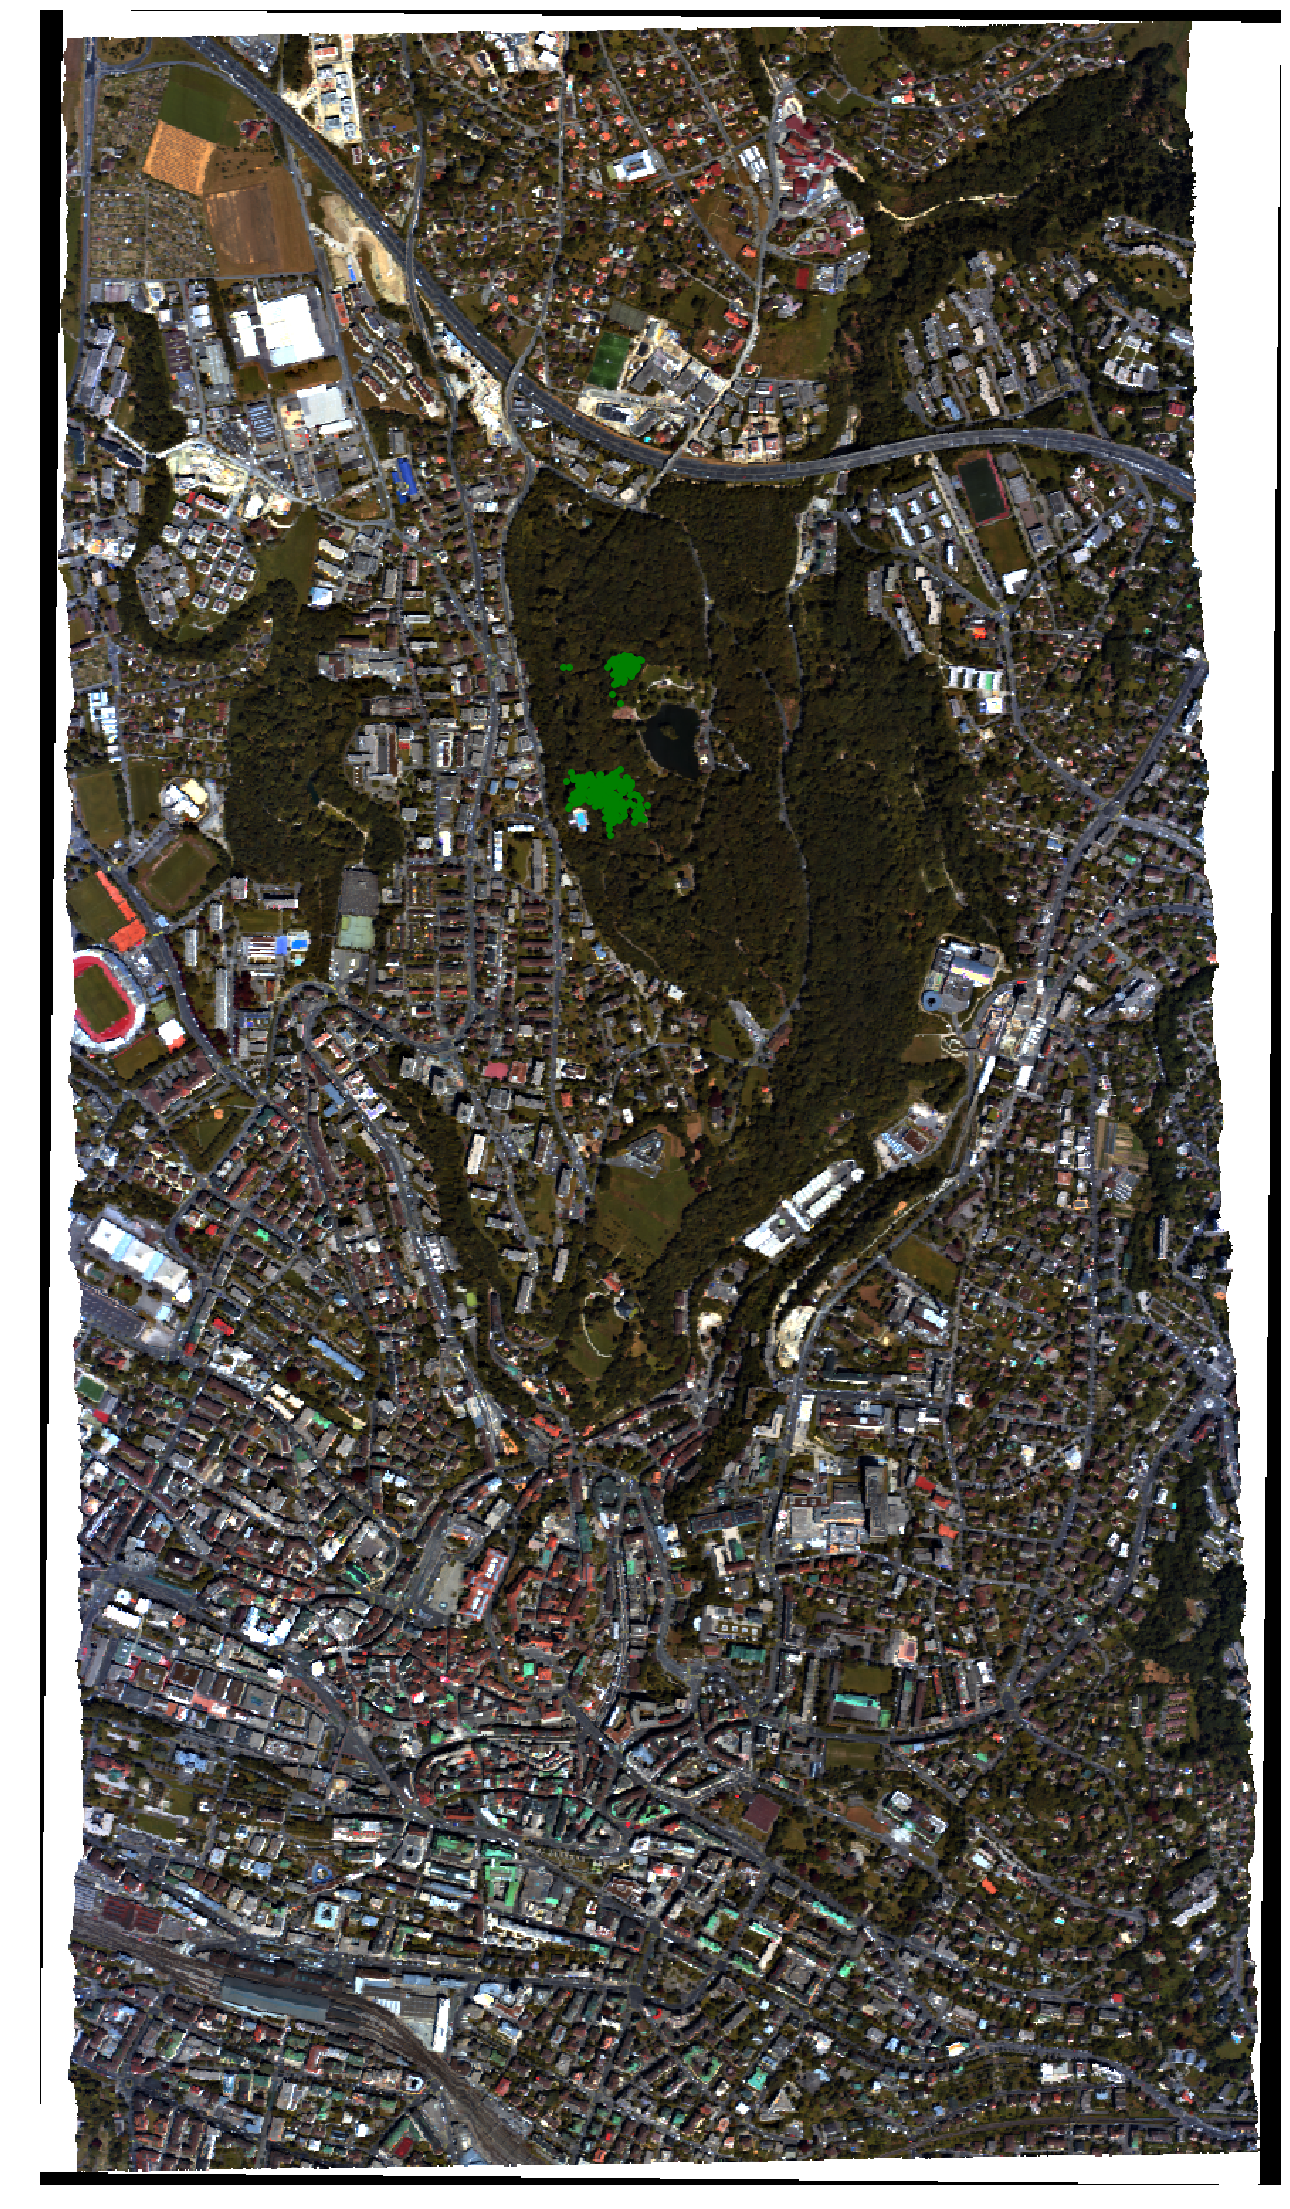

In [5]:
MData = src_ds.GetMetadata()
Wavelength = np.asarray([ float(valeur[:-12]) for cle, valeur in MData.items() if cle[:4]=='Band'])
BandN = [ cle for cle, valeur in MData.items() if cle[:4]=='Band']

RGB = np.array([0.7, 0.55, 0.45])
RGB_ind = np.argmin(np.abs(RGB - np.tile(Wavelength,[3,1]).T), axis=0)

print('RGB Bands:')
for ind in RGB_ind:
    print(str(BandN[ind])+" Wavelength "+str(Wavelength[ind]))
    
R = src_ds.GetRasterBand(58).ReadAsArray()
G = src_ds.GetRasterBand(16).ReadAsArray()
B = src_ds.GetRasterBand(4).ReadAsArray()

Random = np.dstack((src_ds.GetRasterBand(98).ReadAsArray(),\
                    src_ds.GetRasterBand(8).ReadAsArray(), \
                    src_ds.GetRasterBand(178).ReadAsArray()))
#Random = img_crop(Random, 380, 600, 400, 650)
RGB_img = np.dstack((R,G,B))
better_contrast = RGB_img[:]
del R, G, B

for i in range(RGB_img.shape[2]):
    v_min, v_max = np.percentile(RGB_img[:,:,i], (1, 92))
    v_min, v_max
    better_contrast[:,:,i] = exposure.rescale_intensity(RGB_img[:,:,i], in_range=(v_min, v_max))
    
    v_min, v_max = np.percentile(Random[:,:,i], (10, 90))
    v_min, v_max
    Random[:,:,i] = exposure.rescale_intensity(Random[:,:,i], in_range=(v_min, v_max))
    
    
    
ID, CX, CY = load_tree_csv('csv/TreeCenter.csv')

#better_contrast = img_crop(better_contrast, 30, 45, 672, 723)

plt.figure(figsize=(40, 40))
#plt.subplot(1, 2, 1)
plt.imshow(better_contrast)
plt.axis('off')
plt.scatter(CX, CY,c='g', zorder=2)
#plt.subplot(1, 2, 2)
#plt.imshow(Random)
#plt.axis('off')
plt.savefig("IllustrationSauva", dpi='figure')

# # Import Data

In [55]:
HeaderName, ids, X = load_train_csv("csv/TrainIndices.csv")
print("Header: \n")
print(HeaderName)
print("Data: \n")
print(X)
print("Labels: \n")
print(ids)
print("shape: \n")
%whos

Header: 

['LabelGenus' 'LabelSpecies' 'LabelMixte' 'Label' 'GNDVI' 'B' 'CAI' 'Cl590'
 'DVI' 'EVI' 'G' 'PVI' 'LWI' 'Maxim' 'MSAVI' 'MTCI' 'N' 'NDVI' 'NDWI1240'
 'NDWI1640' 'PRI' 'PSNDa' 'PSSRa' 'ARVI' 'AFVI' 'R' 'TVI' 'REP' 'RVI'
 'SARVI' 'SAVI' 'TSAVI' 'WDRVI']
Data: 

[[ 0.77511829  0.06722744 -0.21139916 ...,  0.5330649  -0.59879636
  -0.52824271]
 [ 0.80882186  0.10432619 -0.22195974 ...,  0.55317383 -0.51221292
  -0.4689044 ]
 [ 0.77080679  0.11460554 -0.17876196 ...,  0.48944958 -0.84759905
  -0.53752275]
 ..., 
 [ 0.85556822  0.0559759  -0.30465253 ...,  0.71275215  0.07812313
  -0.35294292]
 [ 0.84121532  0.03094496 -0.29996813 ...,  0.75266233  0.1788618
  -0.37387118]
 [ 0.83838271  0.0384823  -0.27793266 ...,  0.63751429 -0.1624422
  -0.39483568]]
Labels: 

[[  7   2   7   1]
 [  7   2   7   2]
 [  7   2   7   3]
 [  7   2   7   4]
 [  7   2   7   5]
 [  1   1   1   6]
 [  1   1   1   7]
 [  9   7   9   8]
 [  9   7   9   9]
 [  9   7   9  10]
 [  9   7   9  11]
 [  4   9   

In [57]:
count = 0
for i in range(4,len(HeaderName)):
    count +=1 
    print(count, '&', HeaderName[i],'\\\\')

1 & GNDVI \\
2 & B \\
3 & CAI \\
4 & Cl590 \\
5 & DVI \\
6 & EVI \\
7 & G \\
8 & PVI \\
9 & LWI \\
10 & Maxim \\
11 & MSAVI \\
12 & MTCI \\
13 & N \\
14 & NDVI \\
15 & NDWI1240 \\
16 & NDWI1640 \\
17 & PRI \\
18 & PSNDa \\
19 & PSSRa \\
20 & ARVI \\
21 & AFVI \\
22 & R \\
23 & TVI \\
24 & REP \\
25 & RVI \\
26 & SARVI \\
27 & SAVI \\
28 & TSAVI \\
29 & WDRVI \\


# Check Dimensionality

In [56]:
# Print feature statistics
NClasse = np.max(ids[:,0:3], axis=0)
print('Recorded ' + str(X.shape[0]) + ' trees')
print('Feature dimension = ' + str(X.shape[1]))
print('Numbers of classes = ' + str(NClasse))

YC = [ [ [] for N in range(NClasse[n])] for n in range(ids.shape[1]-1)]
for i in range(NClasse.shape[0]):
    YC[i] = [ [ids[k,3] for k, l in enumerate(ids[:,i]) if l == j] for j in range(1,NClasse[0]+1)]
    for j in range(1,NClasse[0]+1):
        print('LabelType :' + str(HeaderName[i]) + 'Class '+ str(j) + ': ' + str(len(YC[i][j-1])) + ' samples')
    print("\n")

    
# Removal of class with less than 19 observation
ind = bool()
    
Label_choosen = 2
for j in range(1,NClasse[0]+1):
    if len(YC[Label_choosen][j-1]) < 19:
        ind = np.logical_or(ismember(YC[Label_choosen][j-1], ids[:,3]),ind)
        
ids = ids[np.logical_not(ind),:]
tY = ids[:,Label_choosen]
tX = X[np.logical_not(ind),:]
#tY = ids[:,Label_choosen]

# Print feature statistics
print('Recorded ' + str(tX.shape[0]) + ' trees')
print('Feature dimension = ' + str(tX.shape[1]))
print('Numbers of classes = ' + str(NClasse))
del YC
YC = [ [ [] for N in range(NClasse[n])] for n in range(ids.shape[1]-1)]
for i in range(NClasse.shape[0]):
    YC[i] = [ [ids[k,3] for k, l in enumerate(ids[:,i]) if l == j] for j in range(1,NClasse[0]+1)]
    for j in range(1,NClasse[0]+1):
        print('LabelType :' + str(HeaderName[i]) + 'Class '+ str(j) + ': ' + str(len(YC[i][j-1])) + ' samples')
    print("\n")
        

Recorded 233 trees
Feature dimension = 29
Numbers of classes = [10  9 10]
LabelType :LabelGenusClass 1: 52 samples
LabelType :LabelGenusClass 2: 2 samples
LabelType :LabelGenusClass 3: 3 samples
LabelType :LabelGenusClass 4: 73 samples
LabelType :LabelGenusClass 5: 1 samples
LabelType :LabelGenusClass 6: 19 samples
LabelType :LabelGenusClass 7: 33 samples
LabelType :LabelGenusClass 8: 2 samples
LabelType :LabelGenusClass 9: 47 samples
LabelType :LabelGenusClass 10: 1 samples


LabelType :LabelSpeciesClass 1: 53 samples
LabelType :LabelSpeciesClass 2: 33 samples
LabelType :LabelSpeciesClass 3: 2 samples
LabelType :LabelSpeciesClass 4: 19 samples
LabelType :LabelSpeciesClass 5: 1 samples
LabelType :LabelSpeciesClass 6: 2 samples
LabelType :LabelSpeciesClass 7: 47 samples
LabelType :LabelSpeciesClass 8: 3 samples
LabelType :LabelSpeciesClass 9: 73 samples
LabelType :LabelSpeciesClass 10: 0 samples


LabelType :LabelMixteClass 1: 52 samples
LabelType :LabelMixteClass 2: 2 samples
LabelType

# Perform features Muliplication

In [30]:
tX = Features_Product(tX)
scaler2 = preprocessing.StandardScaler().fit(tX)
tX = np.array(scaler2.transform(tX))

tX.shape

(224, 34981)

# Perform features reduction by PCA

In [31]:
# Perform pca and scale data

scaler = preprocessing.StandardScaler().fit(tX)
tX = scaler.transform(tX)
usePca = 1
mod = 'Full'
VarKeeped = 99.99 # Variance keeped in percent %
if usePca:
    print(tX.shape[1])
    pca = PCA()
    tX_reduced = pca.fit(tX).transform(tX)
    numberOfFeatures = np.sum(VarKeeped>np.cumsum((pca.explained_variance_ratio_)*100))

    print('Number Principal Component : ',numberOfFeatures), print('for', str(VarKeeped),'percent of variance keeped\n')
    print(VarKeeped>np.cumsum((pca.explained_variance_ratio_)*100))
    if mod == 'Full':
        tX = np.array(tX_reduced[:,:])
    else:
        tX = np.array(tX_reduced[:,0:numberOfFeatures])
    print(tX_reduced.shape)
    print(tX.shape)
else:
    tX = np.array(scaler.transform(tX))
    
scaler.mean_.shape
    


34981
Number Principal Component :  37
for 99.99 percent of variance keeped

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False Fals

(34981,)

In [ ]:
print(pca)

# Perform Cross-validation
# Kernel Linear

In [ ]:
import warnings
warnings.filterwarnings('ignore')

C_range = np.logspace(-10,3,num= 28)

K_fold = 4
Acc_test = []
score_test = []
Acc_train = []
score_train = []

# Initialize folder
skf = StratifiedKFold(n_splits=K_fold)
#skf = StratifiedShuffleSplit(n_splits=1, test_size=0.25)
skf.get_n_splits(tX, tY)

for c in C_range:   
    
    print("C = exp(%.2f)"%(np.log10(c)))

    Acc_te_tmp = []
    score_te_tmp = []
    Acc_tr_tmp = []
    score_tr_tmp = []

    for train_index, test_index in skf.split(tX, tY):

        # get k'th subgroup in test, others in train
        x_te, y_te = tX[test_index], tY[test_index]
        x_tr, y_tr = tX[train_index], tY[train_index]

        # Stritified factor correction
        uid = np.unique(y_tr)
        Cumul = np.asarray([np.int(np.sum(y_tr==uid[i])) for i in range(uid.shape[0])])
        tot = np.sum(Cumul)
        weight = {uid[i]: (Cumul[i]/tot) for i in range(uid.shape[0])}
        weightN = np.asarray([(Cumul[k]/tot) for k in range(uid.shape[0]) for j in y_tr if j==uid[k]])

        # Model initilization
        model = svm.LinearSVC(C=c, penalty='l1', max_iter=1000, tol=1e-6, dual=False,  fit_intercept=False)
        #model = MLPClassifier(solver='lbfgs', alpha=c, random_state=1)

        # Model training
        model.fit(x_tr, y_tr, sample_weight=weightN)

        # Predict on the training and test set
        Z_test = model.predict(x_te)
        Z_train = model.predict(x_tr)

        # Metrics computation
        # --- Teste scores
        Acc_te_tmp.append(metrics.accuracy_score(y_te,Z_test))
        score_te_tmp.append(metrics.f1_score(y_te,Z_test, average='weighted'))
        # --- Train scores
        Acc_tr_tmp.append(metrics.accuracy_score(y_tr,Z_train))
        score_tr_tmp.append(metrics.f1_score(y_tr,Z_train, average='weighted'))

    # Metrics computation
    # --- Teste scores
    Acc_test.append(np.mean(Acc_te_tmp))
    score_test.append(np.mean(score_te_tmp))
    # --- Train scores
    Acc_train.append(np.mean(Acc_tr_tmp))
    score_train.append(np.mean(score_tr_tmp))

print(np.max(score_test))
# PCA 100% : 0.66981776119574399
# PCA 100% -> multiplicateur : 0.19
# multiplicateur -> PCA 100%: 0.63241400478822141
# PCA 100% est mieux que PCA Full

In [ ]:
SpecPP = "_MultiRaw" # To be change !!!
plt.figure(figsize=(10, 10))
plt.semilogx(C_range, np.asarray(score_train), marker=".", color='b', label='train Fmeasure')
plt.semilogx(C_range, np.asarray(score_test), marker=".", color='r', label='test Fmeasure')
plt.semilogx(C_range, np.asarray(Acc_train), marker=".",linestyle="--", color='b', label='train accuracy')
plt.semilogx(C_range, np.asarray(Acc_test), marker=".",linestyle="--", color='r', label='test accuracy')
plt.xlabel("C")
plt.ylabel("Score")
plt.title("cross validation: 4 Stratified_fold, features: Raw, Kernel: Lineaire, Post-Processing: "+SpecPP)
plt.legend(loc=0)
plt.grid(True)
np.max(score_test)
plt.savefig("figures/Raw/Lineaire"+SpecPP) 
MaxPos = np.argmax(score_test)

with open('figures/Raw/Results.txt', 'a') as mon_fichier:
    mon_fichier.write('\n')
    mon_fichier.write('\n')
    mon_fichier.write('--------------------------------------------------------------------------')
    mon_fichier.write('\n')
    print('-----> PostProcessing : ',SpecPP, file=mon_fichier)
    mon_fichier.write(str(model))
    mon_fichier.write('\n')
    print('Best Fmeasure:', str(score_test[MaxPos]),', -> accuracy: ', str(Acc_test[MaxPos]), file=mon_fichier)
    mon_fichier.write('--------------------------------------------------------------------------')
                      

# Kernel : RBF

In [32]:
import warnings
warnings.filterwarnings('ignore')

C_range = np.logspace(-4,10,num= 25)
gamma_range = np.logspace(-15, 3, num=20)
K_fold = 4
Acc_test = []
score_test = []
Acc_train = []
score_train = []

# Initialize folder
skf = StratifiedKFold(n_splits=K_fold)
#skf = StratifiedShuffleSplit(n_splits=1, test_size=0.25)
skf.get_n_splits(tX, tY)

for c in C_range:  
    
    print("C = exp(%.2f)"%(np.log10(c)))
    for g in gamma_range:
    
        print("Gamma = exp(%.2f)"%(np.log10(g)))
        Acc_te_tmp = []
        score_te_tmp = []
        Acc_tr_tmp = []
        score_tr_tmp = []

        for train_index, test_index in skf.split(tX, tY):
            
            # get k'th subgroup in test, others in train
            x_te, y_te = tX[test_index], tY[test_index]
            x_tr, y_tr = tX[train_index], tY[train_index]
            
            # Stritified factor correction
            uid = np.unique(y_tr)
            Cumul = np.asarray([np.int(np.sum(y_tr==uid[i])) for i in range(uid.shape[0])])
            tot = np.sum(Cumul)
            weight = {uid[i]: (Cumul[i]/tot) for i in range(uid.shape[0])}
            weightN = np.asarray([100*(Cumul[k]/tot) for k in range(uid.shape[0]) for j in y_tr if j==uid[k]])
            
            # Model initilization
            model = svm.SVC(C=c ,cache_size= 10000,  kernel='rbf', gamma=g)
            #model = MLPClassifier(solver='lbfgs', alpha=c, random_state=1)

            # Model training
            model.fit(x_tr, y_tr, sample_weight=weightN)

            # Predict on the training and test set
            Z_test = model.predict(x_te)
            Z_train = model.predict(x_tr)

            # Metrics computation
            # --- Teste scores
            Acc_te_tmp.append(metrics.accuracy_score(y_te,Z_test))
            score_te_tmp.append(metrics.f1_score(y_te,Z_test, average='weighted'))
            # --- Train scores
            Acc_tr_tmp.append(metrics.accuracy_score(y_tr,Z_train))
            score_tr_tmp.append(metrics.f1_score(y_tr,Z_train, average='weighted'))
        
        # Metrics computation
        # --- Teste scores
        Acc_test.append(np.mean(Acc_te_tmp))
        score_test.append(np.mean(score_te_tmp))
        # --- Train scores
        Acc_train.append(np.mean(Acc_tr_tmp))
        score_train.append(np.mean(score_tr_tmp))
        
# Metrics computation
# --- Teste scores        
Acc_test = np.asarray(Acc_test).reshape(len(C_range),len(gamma_range))
score_test = np.asarray(score_test).reshape(len(C_range),len(gamma_range))
# --- Train scores
Acc_train = np.asarray(Acc_train).reshape(len(C_range),len(gamma_range))
score_train = np.asarray(score_train).reshape(len(C_range),len(gamma_range))


# PCA 100% : 0.661386789504
# multiplicateur -> PCA 100%:0.66727337198

C = exp(-4.00)
Gamma = exp(-15.00)
Gamma = exp(-14.05)
Gamma = exp(-13.11)
Gamma = exp(-12.16)
Gamma = exp(-11.21)
Gamma = exp(-10.26)
Gamma = exp(-9.32)
Gamma = exp(-8.37)
Gamma = exp(-7.42)
Gamma = exp(-6.47)
Gamma = exp(-5.53)
Gamma = exp(-4.58)
Gamma = exp(-3.63)
Gamma = exp(-2.68)
Gamma = exp(-1.74)
Gamma = exp(-0.79)
Gamma = exp(0.16)
Gamma = exp(1.11)
Gamma = exp(2.05)
Gamma = exp(3.00)
C = exp(-3.42)
Gamma = exp(-15.00)
Gamma = exp(-14.05)
Gamma = exp(-13.11)
Gamma = exp(-12.16)
Gamma = exp(-11.21)
Gamma = exp(-10.26)
Gamma = exp(-9.32)
Gamma = exp(-8.37)
Gamma = exp(-7.42)
Gamma = exp(-6.47)
Gamma = exp(-5.53)
Gamma = exp(-4.58)
Gamma = exp(-3.63)
Gamma = exp(-2.68)
Gamma = exp(-1.74)
Gamma = exp(-0.79)
Gamma = exp(0.16)
Gamma = exp(1.11)
Gamma = exp(2.05)
Gamma = exp(3.00)
C = exp(-2.83)
Gamma = exp(-15.00)
Gamma = exp(-14.05)
Gamma = exp(-13.11)
Gamma = exp(-12.16)
Gamma = exp(-11.21)
Gamma = exp(-10.26)
Gamma = exp(-9.32)
Gamma = exp(-8.37)
Gamma = exp(-7.42)
Gamma = exp(-6

Maximum F1_score:  0.665077421225
Accuracy following best F_score:  0.679170087575
_Multi


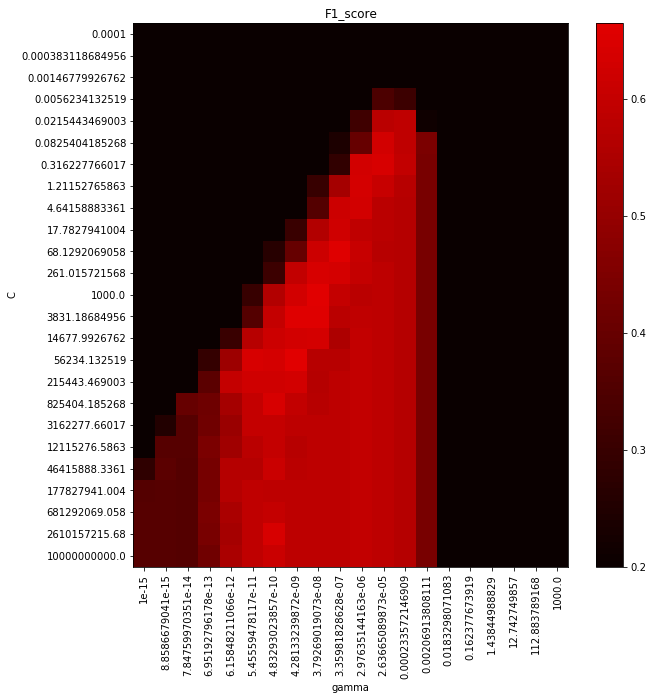

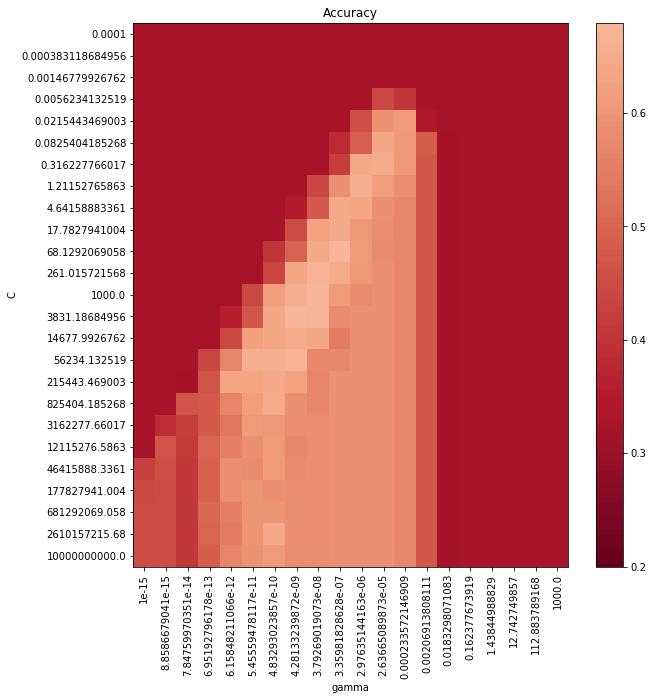

In [27]:
SpecPP = "_Multi" # To be change !!!

plt.figure(figsize=(10, 10))
plt.imshow(score_test, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=90)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('F1_score')
plt.savefig("figures/Raw/F1Kernel"+SpecPP) 

plt.figure(figsize=(10, 10))
plt.imshow(Acc_test, interpolation='nearest', cmap='RdBu',
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=90)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Accuracy')
plt.savefig("figures/Raw/AccKernel"+SpecPP) 

print('Maximum F1_score: ', np.max(score_test))
MaxPos = np.argmax(score_test)
CMaxPos = MaxPos//len(gamma_range)
GMaxPos = MaxPos - CMaxPos*len(gamma_range)
assert(score_test[CMaxPos, GMaxPos] == np.max(score_test))
print('Accuracy following best F_score: ',Acc_test[CMaxPos, GMaxPos])
print(SpecPP)

# Result
with open('figures/Raw/KernelResults.txt', 'a') as mon_fichier:
    mon_fichier.write('\n')
    mon_fichier.write('\n')
    mon_fichier.write('--------------------------------------------------------------------------')
    mon_fichier.write('\n')
    print('-----> PostProcessing : ',SpecPP, file=mon_fichier)
    mon_fichier.write(str(model))
    mon_fichier.write('\n')
    print('Best C: ', C_range[CMaxPos], 'Best Gamma: ', gamma_range[GMaxPos], file=mon_fichier)
    print('Accuracy following best F_score: ',Acc_test[CMaxPos, GMaxPos],file=mon_fichier)
    print('Best F1_score: ', np.max(score_test),file=mon_fichier)
    mon_fichier.write('--------------------------------------------------------------------------')
                      

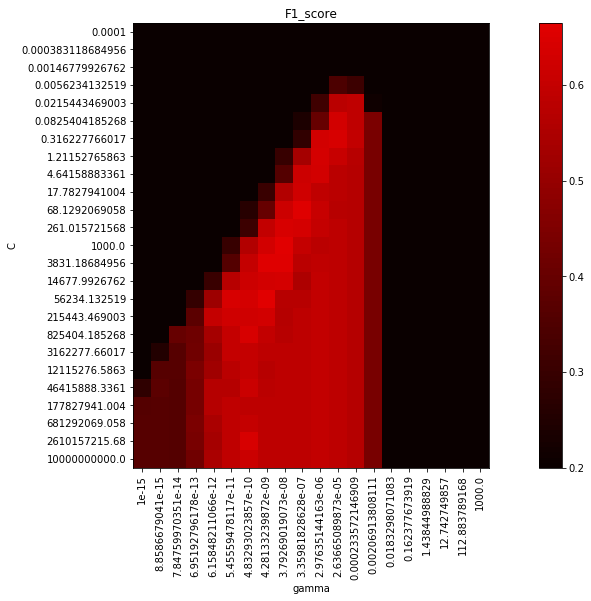

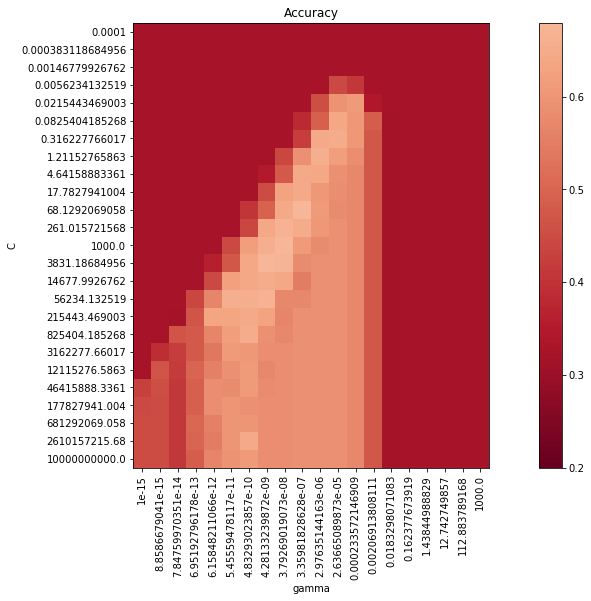

Best C:  1000.0 Best Gamma:  3.79269019073e-08
Accuracy following best F_score:  0.679170087575
Maximum F1_score:  0.665077421225


In [33]:

plt.figure(figsize=(18, 18))
plt.subplot(2,1,1)
plt.imshow(score_test, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=90)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('F1_score')
plt.show()

plt.figure(figsize=(18, 18))
plt.subplot(2,1,2)
plt.imshow(Acc_test, interpolation='nearest', cmap='RdBu',
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=90)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Accuracy')
plt.show()


MaxPos = np.argmax(score_test)
CMaxPos = MaxPos//len(gamma_range)
GMaxPos = MaxPos - CMaxPos*len(gamma_range)
print('Best C: ', C_range[CMaxPos], 'Best Gamma: ', gamma_range[GMaxPos])
assert(score_test[CMaxPos, GMaxPos] == np.max(score_test))
print('Accuracy following best F_score: ',Acc_test[CMaxPos, GMaxPos])
print('Maximum F1_score: ', np.max(score_test))
# PCA Full mieux que PCA 100%

In [ ]:
from sklearn import svm
from sklearn.neural_network import MLPClassifier
KernelSession = 'poly'

import warnings
warnings.filterwarnings('ignore')

C_range = np.logspace(-10,3,num= 9)
gamma_range = np.logspace(-15, 5, 15)
degree_range = np.arange(1,3)
coef0_range = np.logspace(-1,1,num= 5)
K_fold = 4
Acc_test = []
score_test = []
Acc_train = []
score_train = []

# Initialize folder
skf = StratifiedKFold(n_splits=K_fold)
#skf = StratifiedShuffleSplit(n_splits=1, test_size=0.25)
skf.get_n_splits(tX, tY)

for c in C_range:   
    
    print("C = exp(%.2f)"%(np.log10(c)))
    for g in gamma_range:
        
        print("gamma = exp(%.2f)"%(np.log10(g)))
        for d in degree_range:
            for c0 in coef0_range:
            
    
                Acc_te_tmp = []
                score_te_tmp = []
                Acc_tr_tmp = []
                score_tr_tmp = []

                for train_index, test_index in skf.split(tX, tY):

                    # get k'th subgroup in test, others in train
                    x_te, y_te = tX[test_index], tY[test_index]
                    x_tr, y_tr = tX[train_index], tY[train_index]

                    # Stritified factor correction
                    uid = np.unique(y_tr)
                    Cumul = np.asarray([np.int(np.sum(y_tr==uid[i])) for i in range(uid.shape[0])])
                    tot = np.sum(Cumul)
                    weight = {uid[i]: (Cumul[i]/tot) for i in range(uid.shape[0])}
                    weightN = np.asarray([100*(Cumul[k]/tot) for k in range(uid.shape[0]) for j in y_tr if j==uid[k]])

                    # Model initilization
                    model = svm.SVC(C=c ,cache_size= 10000,  kernel='poly', degree=d, coef0=c0, gamma=g)
                    #model = MLPClassifier(solver='lbfgs', alpha=c, random_state=1)

                    # Model training
                    model.fit(x_tr, y_tr, sample_weight=weightN)

                    # Predict on the training and test set
                    Z_test = model.predict(x_te)
                    Z_train = model.predict(x_tr)

                    # Metrics computation
                    # --- Teste scores
                    Acc_te_tmp.append(metrics.accuracy_score(y_te,Z_test))
                    score_te_tmp.append(metrics.f1_score(y_te,Z_test, average='weighted'))
                    # --- Train scores
                    Acc_tr_tmp.append(metrics.accuracy_score(y_tr,Z_train))
                    score_tr_tmp.append(metrics.f1_score(y_tr,Z_train, average='weighted'))

                # Metrics computation
                # --- Teste scores
                Acc_test.append(np.mean(Acc_te_tmp))
                score_test.append(np.mean(score_te_tmp))
                # --- Train scores
                Acc_train.append(np.mean(Acc_tr_tmp))
                score_train.append(np.mean(score_tr_tmp))
        
# Metrics computation
# --- Teste scores        
Acc_test = np.asarray(Acc_test).reshape(len(C_range),len(gamma_range), len(degree_range), len(coef0_range))
score_test = np.asarray(score_test).reshape(len(C_range),len(gamma_range), len(degree_range), len(coef0_range))
# --- Train scores
Acc_train = np.asarray(Acc_train).reshape(len(C_range),len(gamma_range), len(degree_range), len(coef0_range))
score_train = np.asarray(score_train).reshape(len(C_range),len(gamma_range), len(degree_range), len(coef0_range))


# multiplicateur -> PCA 100%:0.662586745241

In [ ]:
from matplotlib.colors import Normalize

MaxBmap= score_test==np.max(score_test)
CMaxPos = np.argmax(np.sum(MaxBmap, axis=(1,2,3)))
GMaxPos = np.argmax(np.sum(MaxBmap, axis=(0,2,3)))
DMaxPos = np.argmax(np.sum(MaxBmap, axis=(0,1,3)))
C0MaxPos = np.argmax(np.sum(MaxBmap, axis=(0,1,2)))
assert(score_test[CMaxPos, GMaxPos, DMaxPos, C0MaxPos] == np.max(score_test))

print('Maximum F1_score: ', np.max(score_test))
print('Best C: ', C_range[CMaxPos],\
      'Best Gamma: ', gamma_range[GMaxPos],\
      'Best degree: ', degree_range[DMaxPos],\
      'Best coef0: ', coef0_range[C0MaxPos])

plt.figure(figsize=(18, 18))
plt.subplot(2,1,1)
plt.imshow(score_test[:,:, DMaxPos, C0MaxPos], interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=90)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('F1_score')
plt.show()

plt.figure(figsize=(18, 18))
plt.subplot(2,1,2)
plt.imshow(Acc_test[:,:, DMaxPos, C0MaxPos], interpolation='nearest', cmap='RdBu',
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=90)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Accuracy')
plt.show()

In [ ]:
score_test[CMaxPos, GMaxPos]

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import Normalize

# Utility function to move the midpoint of a colormap to be around
# the values of interest.
K_fold = 4
skf = StratifiedKFold(n_splits=K_fold)
#skf = StratifiedShuffleSplit(n_splits=1, test_size=0.25)
#skf.get_n_splits(tX, tY)

C_range = np.logspace(-2, 10, 20)
gamma_range = np.logspace(-15, 1, 20)
param_grid = {'gamma':gamma_range, 'C':C_range, 'kernel':['rbf'], 'class_weight':['balanced']}
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, scoring='f1_weighted')
grid
grid.fit(tX, tY)

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=90)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('F1_score')
plt.show()

print(grid.best_score_)
print(grid.best_params_)

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import Normalize

import warnings
warnings.filterwarnings('ignore')

# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))


K_fold = 4
skf = StratifiedKFold(n_splits=K_fold)
#skf = StratifiedShuffleSplit(n_splits=1, test_size=0.25)
#skf.get_n_splits(tX, tY)

C_range = np.logspace(-2, 15, 20)
gamma_range = np.logspace(-15, 1, 20)
param_grid = {'gamma':gamma_range, 'C':C_range, 'kernel':['poly'], 'class_weight':['balanced']}
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, scoring='f1_weighted')
grid
grid.fit(tX, tY)

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))
plt.figure(figsize=(8, 6))
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('F1_score')
plt.show()

print(grid.best_score_)
print(grid.best_params_)

In [ ]:
from sklearn import svm
from sklearn.neural_network import MLPClassifier

#X = np.array(X_reduced)

C = np.logspace(-8,8,num= 24)
TPR_test = []
score_test = []
TPR_train = []
score_train = []
K_fold = 4
seed = None
#k_indices = build_k_indices(Y, K_fold, seed)
usePca = 0


skf = StratifiedKFold(n_splits=K_fold)
skf.get_n_splits(tX, tY)

for c in C:   
    
    print("C = exp(%.2f)"%(np.log10(c)))
    TPR_te_tmp = []
    score_te_tmp = []
    TPR_tr_tmp = []
    score_tr_tmp = []
    
    for train_index, test_index in skf.split(tX, tY):
        uid = np.unique(tY[train_index])
        Cumul = np.asarray([np.int(np.sum(tY[train_index]==uid[i])) for i in range(uid.shape[0])])
        tot = np.sum(Cumul)
        weight = {uid[i]: tot/Cumul[i] for i in range(uid.shape[0])}
        #model = svm.SVC(C=c ,cache_size= 10000, class_weight=weight, kernel='linear')
        model = MLPClassifier(solver='lbfgs', alpha=c, random_state=1)
        
        # Predictions
        # ----------------------------------
        # get k'th subgroup in test, others in train
        x_te, y_te = tX[test_index], tY[test_index]
        x_tr, y_tr = tX[train_index], tY[train_index]

        # train model
        model.fit(x_tr, y_tr)

        # form data with polynomial degree
        # Predict on the training set
        Z_test = model.predict(x_te)
        Z_train = model.predict(x_tr)
        ## Get non-zeros in prediction and grountruth arrays
        #Z_testn = np.nonzero(Z_test)[0]
        #Z_trainn = np.nonzero(Z_train)[0]
        #Y_testn = np.nonzero(y_te)[0]
        #Y_trainn = np.nonzero(y_tr)[0]

        ## Compute scores
        #TPR_testc = len(list(set(Y_testn) & set(Z_testn))) / float(len(Y_testn))
        #score_testc = metrics.f1_score(y_te,Z_test)

        #TPR_trainc = len(list(set(Y_trainn) & set(Z_trainn))) / float(len(Y_trainn))
        #score_trainc = metrics.f1_score(y_tr,Z_train, average='weighted')
        #return score_trainc, score_testc, TPR_trainc, TPR_testc
        score_trainc = metrics.f1_score(y_tr,Z_train, average='weighted')
        score_testc = metrics.f1_score(y_te,Z_test, average='weighted')
        # ----------------------------------
        
        #TPR_te_tmp.append(TPR_testc)
        score_te_tmp.append(score_testc)
        #TPR_tr_tmp.append(TPR_trainc)
        score_tr_tmp.append(score_trainc)
    
    #TPR_test.append(np.mean(TPR_te_tmp))
    score_test.append(np.mean(score_te_tmp))
    #TPR_train.append(np.mean(TPR_tr_tmp))
    score_train.append(np.mean(score_tr_tmp))

#result_vis(C, score_test, score_train, TPR_test, TPR_train, usePca, balance)
#strLab = str(HeaderName[Label_choosen])

#if usePca :
#    strPca = "_pca"
#    else:
#        strPca="_"

#plt.savefig("figures/bias_variance"+strLab+strPca)
        
plt.semilogx(C, np.asarray(score_train), marker=".", color='b', label='train Fmeasure')
plt.semilogx(C, np.asarray(score_test), marker=".", color='r', label='test Fmeasure')
#plt.semilogx(C, np.asarray(TPR_train), marker=".",linestyle="--", color='b', label='train True P.R.')
#plt.semilogx(C, np.asarray(TPR_test), marker=".",linestyle="--", color='r', label='test True P.R.')
plt.xlabel("Lambda")
plt.ylabel("Score")
plt.legend(loc=0)
plt.grid(True)

# Save models

In [ ]:
np.save("Best_models/SVMrbf_PCA_n100.npy",bestM)
np.save("Best_models/scaler.npy",scaler2)
np.save("Best_models/pac.npy",pca2)

# Load matrix X for complet

In [ ]:
# Load features and segments from testset (1feature_map,2Fourier_map, 3extracted_features)
X_test = np.load("Backup/BackupWithFourierX_test_n100.npy")


# Perform pca and scale test data
if usePca:
    X_test_reduced = pca.transform(scaler2.transform(X_test))
    X_test = np.array(X_test_reduced[:,0:numberOfFeatures])
else:
    X_test = np.array(scaler2.transform(X_test))

# Perform prediction

In [ ]:
# Predict on the training set
Z = bestM.predict(X_test)
print(Z)


In [ ]:

# Save prediction of test set as image
    
print ("Running prediction on test set")

prediction_test_dir = "predictions_test/"

if not os.path.isdir(prediction_test_dir):
    os.mkdir(prediction_test_dir)

for i in range( len(Binary_predict)):
    pimg = concatenate_images_test(Binary_predict[i])

    if i<=8:
        Image.fromarray(pimg).save(prediction_test_dir + "grt_test_0" + str(i+1) + ".png")
    else:
        Image.fromarray(pimg).save(prediction_test_dir + "grt_test_" + str(i+1) + ".png")


